# Kelvin-Helmholtz Instability with SPH (Continued)

By now you should have run a simulation and got a reasonable number of snapshots in the output. This notebook will now ingest those outputs and 

## What we'll do in this notebook

1. **Visualize the results** and create movies
2. **Explore different solvers/parameters** to see how they affect the instability growth

Let's get started!

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
import unyt
from scipy.spatial.distance import cdist
import os
import subprocess
from swiftsimio import Writer
from swiftsimio.units import cosmo_units

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

## 1. Setting up the Initial Conditions

For the Kelvin-Helmholtz instability, we need to create two layers of fluid with different velocities. The function below sets this up for us based on the input arguments. By all means explore different inputs than those demonstrated below but:

- The more particles the longer the simulation will take. We only have limited resources for each student and a limited amount of time for the workshop. In short, don't go too high! But in the same breathe, more particles will give a better result.
- Increasing the box size and keeping the number of particles fixed will decrease the resolution, destroying small scale features due to the poor sampling of the matter field. 
- This comes with no warranty. I'm sure its entirely possible to very readily create a set of ICs which may be malformed in some way.

That all said, review the code below and make sure you understand what it is doing. Then run the function with arguments of your choice to generate a set of initial conditions.

In [12]:
def generate_kelvin_helmholtz_ic(sqrt_n_part, 
                                box_size=[2.0, 1.0], velocity_shear=1.0,
                                density_contrast=2.0, perturbation_amplitude=0.01):
    """
    Generate initial conditions for Kelvin-Helmholtz instability
    
    Parameters:
    -----------
    sqrt_n_part : int
        Square root of the total number of particles (n_particles = sqrt_n_part^2)
    box_size : list
        Size of the simulation box [x, y]
    velocity_shear : float
        Velocity difference between upper and lower layers
    density_contrast : float
        Density ratio between upper and lower layers
    perturbation_amplitude : float
        Amplitude of initial velocity perturbation
    """
    # Create regular grid of particles
    x =np.linspace(0, box_size[0], sqrt_n_part)
    y =np.linspace(0, box_size[1], sqrt_n_part)
    xx, yy = np.meshgrid(x, y)

    # How many particles do we have?
    npart = sqrt_n_part**2
    
    # Add small random offset to avoid perfect grid
    dx = box_size[0] / npart 
    dy = box_size[1] / npart
    xx += np.random.uniform(-0.1*dx, 0.1*dx, xx.shape)
    yy += np.random.uniform(-0.1*dy, 0.1*dy, yy.shape)

    # Flatten arrays and add z=0 coordinate
    pos = np.column_stack([xx.ravel(), yy.ravel(), np.zeros(npart)])    
    
    print(f"Generated {npart} particles")

    # Unpack each coordinate for convenience 
    pos_x, pos_y, pos_z = pos[:, 0], pos[:, 1], pos[:, 2]
    
    # Set up velocities with shear flow
    # Lower half: negative velocity, upper half: positive velocity
    vel_x = np.where(pos_y < box_size[1]/2, -velocity_shear/2, velocity_shear/2)
    vel_y = np.zeros_like(pos_x)
    vel_z = np.zeros_like(pos_x)
    
    # Add small perturbations to trigger instability
    # Sinusoidal perturbation in y-velocity
    wavelength = box_size[0] / 4  # 4 wavelengths across the box
    vel_y += perturbation_amplitude * np.sin(2 * np.pi * pos_x / wavelength) * \
             np.exp(-((pos_y - box_size[1]/2) / (box_size[1]/10))**2)
    
    # Set up densities with contrast
    rho = np.where(pos_y < box_size[1]/2, 1.0, 1.0/density_contrast)
    
    # Particle masses (constant for simplicity)
    total_mass = np.sum(rho) * (box_size[0] * box_size[1]) / npart
    masses = np.full(npart, total_mass / npart)
    
    # Internal energy (constant temperature)
    u = np.full(npart, 1.0)
    
    # Particle IDs
    ids = np.arange(npart, dtype=np.int64)
    
    return {
        'positions': np.column_stack([pos_x, pos_y, pos_z]),
        'velocities': np.column_stack([vel_x, vel_y, vel_z]),
        'masses': masses,
        'densities': rho,
        'internal_energies': u,
        'ids': ids,
        'n_particles': npart,
        'box_size': box_size
    }

# Generate the initial conditions
ic_data = generate_kelvin_helmholtz_ic(150,
                                      box_size=[4.0, 2.0], 
                                      velocity_shear=2.0,
                                      density_contrast=2.0,
                                      perturbation_amplitude=0.1)

print(f"Box size: {ic_data['box_size']}")
print(f"Number of particles: {ic_data['n_particles']}")

Generated 22500 particles
Box size: [4.0, 2.0]
Number of particles: 22500


## 2. Visualizing the Initial Conditions

With the initial conditions generated, we can visualize them to ensure they look as expected. The cell below will create a set of subplots showing the density and velocity fields of the two fluid layers. 

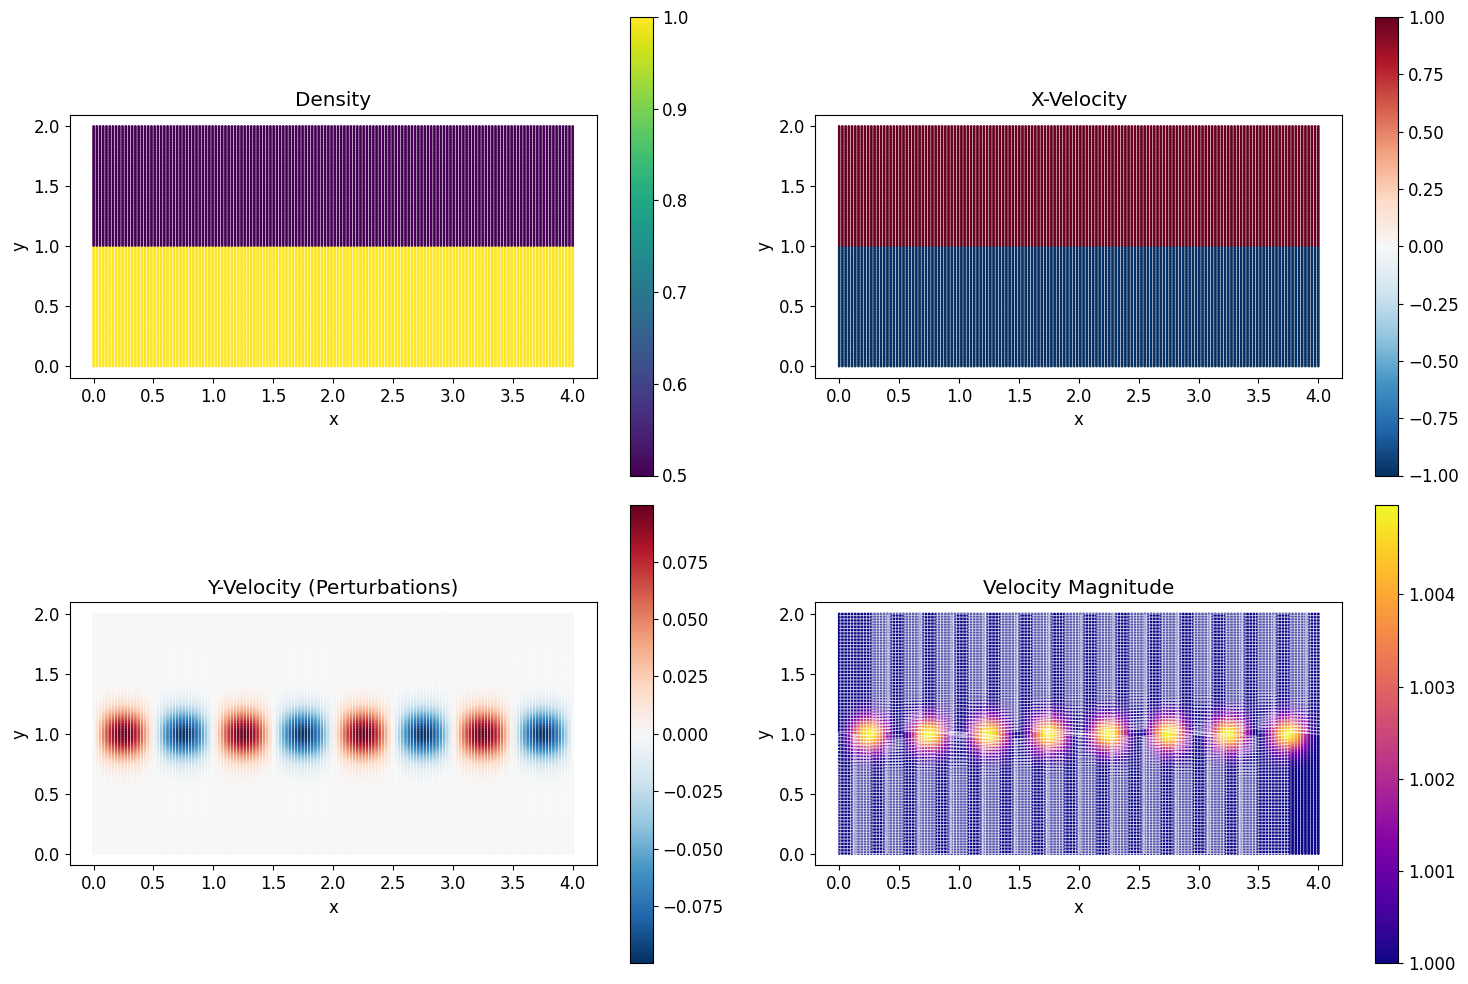

In [13]:
# Plot initial conditions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

pos = ic_data['positions']
vel = ic_data['velocities']
rho = ic_data['densities']

# Density field
im1 = axes[0,0].scatter(pos[:,0], pos[:,1], c=rho, s=1, cmap='viridis')
axes[0,0].set_title('Density')
axes[0,0].set_xlabel('x')
axes[0,0].set_ylabel('y')
axes[0,0].set_aspect('equal')
plt.colorbar(im1, ax=axes[0,0])

# X-velocity field
im2 = axes[0,1].scatter(pos[:,0], pos[:,1], c=vel[:,0], s=1, cmap='RdBu_r')
axes[0,1].set_title('X-Velocity')
axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('y')
axes[0,1].set_aspect('equal')
plt.colorbar(im2, ax=axes[0,1])

# Y-velocity field (perturbations)
im3 = axes[1,0].scatter(pos[:,0], pos[:,1], c=vel[:,1], s=1, cmap='RdBu_r')
axes[1,0].set_title('Y-Velocity (Perturbations)')
axes[1,0].set_xlabel('x')
axes[1,0].set_ylabel('y')
axes[1,0].set_aspect('equal')
plt.colorbar(im3, ax=axes[1,0])

# Velocity magnitude 
vel_mag = np.sqrt(vel[:,0]**2 + vel[:,1]**2)
im4 = axes[1,1].scatter(pos[:,0], pos[:,1], c=vel_mag, s=1, cmap='plasma')
# Add some velocity arrows
skip = 20  # Show every 20th particle
axes[1,1].quiver(pos[::skip,0], pos[::skip,1], 
                vel[::skip,0], vel[::skip,1], 
                scale=10, alpha=0.7, color='white', width=0.002)
axes[1,1].set_title('Velocity Magnitude')
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('y')
axes[1,1].set_aspect('equal')
plt.colorbar(im4, ax=axes[1,1])

plt.tight_layout()
plt.show()

## 3. Writing Initial Conditions to HDF5 File

Before we can run the simulation, we need to write the initial conditions to the HDF5 file that SWIFT ingests. To do this we will use ``swiftsimio``, for more details see the [swiftsimio documentation](https://swiftsimio.readthedocs.io/en/latest/).  

In [14]:
def write_swift_ic_file(ic_data, filename):
    """
    Write initial conditions to SWIFT-compatible HDF5 file
    """
    
    # Ensure output directory exists
    os.makedirs('../ics', exist_ok=True)
    filepath = f'../ics/{filename}'

    # Create the IC writer
    writer = Writer(cosmo_units, boxsize=ic_data['box_size'] * unyt.kpc)

    # Attach all the data we extracted
    writer.gas.coordinates = ic_data['positions'] * unyt.kpc
    writer.gas.velocities = ic_data['velocities'] * unyt.km / unyt.s
    writer.gas.masses = ic_data['masses'] * unyt.Msun
    writer.gas.densities = ic_data['densities'] * unyt.Msun / unyt.kpc**3
    writer.gas.internal_energy = ic_data['internal_energies'] * (unyt.km / unyt.s)**2 

    # Generate initial guess for smoothing lengths based on MIPS
    writer.gas.generate_smoothing_lengths(boxsize=ic_data['box_size'] * unyt.kpc, dimension=2)

    # Write it
    writer.write(filepath)
        
    print(f"Written initial conditions to {filepath}")
    return filepath

# Write the IC file
ic_filename = 'kelvin_helmholtz.hdf5'
ic_filepath = write_swift_ic_file(ic_data, ic_filename)

Written initial conditions to ../ics/kelvin_helmholtz.hdf5


We're nearly there now, just need a way to tell SWIFT what to do and SWIFT itself to execute. 

## 4. Creating Parameter File for SWIFT

We control SWIFT behaviour (i.e. what physics to include, what parameter values to run with and what files to ingest/output), via a yaml file. The cell below contains a simple template with the parameters we will need to run our Kelvin-Helmholtz simulation. 

Note that this template barely scratches the surface of what parameters can be used. You'll see more in the isolated galaxy simulation if you want to explore further.

In [15]:
def create_swift_parameter_file(ic_filename, snap_name='kelvin_helmholtz'):
    """
    Create a SWIFT parameter file for the Kelvin-Helmholtz simulation
    """
    
    # Ensure output directory exists
    os.makedirs('../params', exist_ok=True)
    param_file = f'../params/{snap_name}.yml'
    
    param_content = f"""
# Define the system of units to use internally. 
InternalUnitSystem:
  UnitMass_in_cgs:     1   # grams
  UnitLength_in_cgs:   1   # centimeters 
  UnitVelocity_in_cgs: 1   # centimeters per second
  UnitCurrent_in_cgs:  1   # amperes
  UnitTemp_in_cgs:     1   # kelvin

# Parameters governing the time integration
TimeIntegration:
  time_begin: 0.0    # The starting time of the simulation (in internal units).
  time_end:   2.0    # The end time of the simulation (in internal units).
  dt_min:     1e-6   # The minimal time-step size of the simulation (in internal units).
  dt_max:     1e-2   # The maximal time-step size of the simulation (in internal units).

# Parameters governing the snapshots
Snapshots:
  basename:            {snap_name}  # Common part of the name of output files
  time_first:          0.               # Time of the first output (in internal units)
  delta_time:          0.01      # Time difference between consecutive outputs (in internal units)
  compression:         1              # GZIP compression level (0-9)

# Parameters governing the conserved quantities statistics
Statistics:
  delta_time:          0.01    # Time between statistics output

# Parameters for the hydrodynamics scheme
SPH:
  resolution_eta:        1.2348   # Target smoothing length in units of the mean inter-particle separation
  h_min_ratio:           0.1      # Minimal smoothing length in units of the softening
  h_max:                 10.0     # Maximal smoothing length in internal units
  CFL_condition:         0.2      # Courant-Friedrichs-Levy condition for time integration
  minimal_temperature:   10.0     # Minimal temperature in internal units

# Parameters related to the initial conditions
InitialConditions:
  file_name:  ../ics/{ic_filename}    # The file to read
  periodic:   1                       # Periodic boundary conditions
"""
    
    with open(param_file, 'w') as f:
        f.write(param_content)
    
    print(f"Created parameter file: {param_file}")
    return param_file

# Create parameter file
param_file = create_swift_parameter_file(ic_filename)

Created parameter file: ../params/kelvin_helmholtz.yml


## 5. Running the Simulation



## 6. Analysis and Visualization

Let's create some analysis functions that work whether or not you've run the simulation:

Initial conditions visualization:


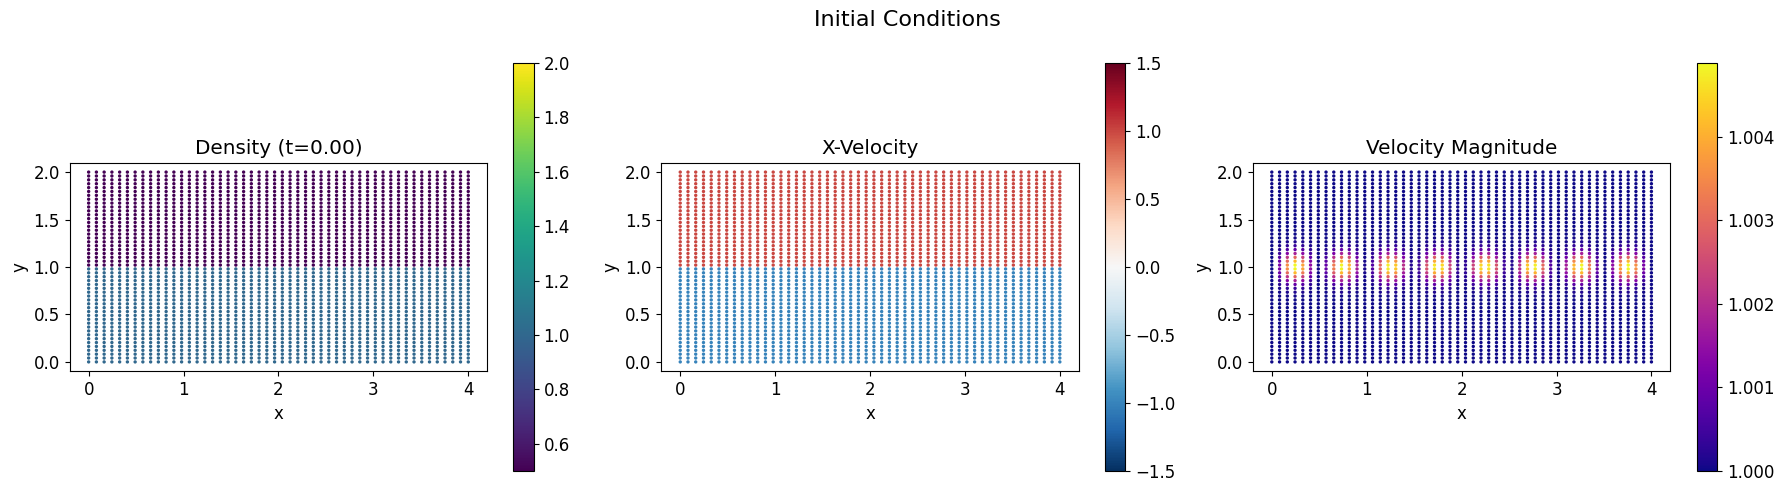

In [6]:
def load_swift_snapshot(filename):
    """
    Load a SWIFT snapshot from HDF5 file
    """
    try:
        with h5py.File(filename, 'r') as f:
            # Read header
            header = f['Header']
            time = header.attrs['Time']
            box_size = header.attrs['BoxSize']
            
            # Read particle data
            part0 = f['PartType0']
            
            data = {
                'time': time,
                'box_size': box_size,
                'positions': part0['Coordinates'][:],
                'velocities': part0['Velocities'][:],
                'densities': part0['Density'][:] if 'Density' in part0 else None,
                'internal_energy': part0['InternalEnergy'][:],
                'smoothing_length': part0['SmoothingLength'][:],
                'masses': part0['Masses'][:]
            }
            
        return data
    except Exception as e:
        print(f"Error loading snapshot {filename}: {e}")
        return None

def plot_snapshot(data, title="", save_path=None):
    """
    Create a visualization of a snapshot
    """
    if data is None:
        print("No data to plot")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    pos = data['positions']
    vel = data['velocities']
    
    # Density plot
    if data['densities'] is not None:
        im1 = axes[0].scatter(pos[:,0], pos[:,1], c=data['densities'], 
                             s=2, cmap='viridis', vmin=0.5, vmax=2.0)
        axes[0].set_title(f'Density (t={data["time"]:.2f})')
        plt.colorbar(im1, ax=axes[0])
    else:
        axes[0].scatter(pos[:,0], pos[:,1], s=1, alpha=0.6)
        axes[0].set_title(f'Particle positions (t={data["time"]:.2f})')
    
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].set_aspect('equal')
    
    # X-velocity
    im2 = axes[1].scatter(pos[:,0], pos[:,1], c=vel[:,0], 
                         s=2, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    axes[1].set_title('X-Velocity')
    axes[1].set_xlabel('x') 
    axes[1].set_ylabel('y')
    axes[1].set_aspect('equal')
    plt.colorbar(im2, ax=axes[1])
    
    # Vorticity (curl of velocity)
    # For 2D: ω = ∂v_x/∂y - ∂v_y/∂x
    # We'll approximate this using local finite differences
    try:
        # Simple approximation of vorticity
        vel_mag = np.sqrt(vel[:,0]**2 + vel[:,1]**2)
        im3 = axes[2].scatter(pos[:,0], pos[:,1], c=vel_mag, 
                             s=2, cmap='plasma')
        axes[2].set_title('Velocity Magnitude')
        plt.colorbar(im3, ax=axes[2])
    except:
        axes[2].scatter(pos[:,0], pos[:,1], c=vel[:,1], 
                       s=2, cmap='RdBu_r')
        axes[2].set_title('Y-Velocity')
    
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y') 
    axes[2].set_aspect('equal')
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

# Test with initial conditions
print("Initial conditions visualization:")
# Convert our IC data to the format expected by plot_snapshot
ic_plot_data = {
    'time': 0.0,
    'box_size': ic_data['box_size'],
    'positions': ic_data['positions'],
    'velocities': ic_data['velocities'],
    'densities': ic_data['densities'],
    'internal_energy': ic_data['internal_energies'],
    'smoothing_length': None,
    'masses': ic_data['masses']
}

plot_snapshot(ic_plot_data, "Initial Conditions")

## 7. Loading and Analyzing Simulation Results

If the simulation ran successfully, let's load and analyze the results:

In [7]:
import glob

# Look for snapshot files
snapshot_files = sorted(glob.glob('../snapshots/kelvin_helmholtz_*.hdf5'))

if snapshot_files:
    print(f"Found {len(snapshot_files)} snapshot files")
    
    # Load and plot a few snapshots
    snapshot_indices = [0, len(snapshot_files)//4, len(snapshot_files)//2, -1]
    
    for i in snapshot_indices:
        if i < len(snapshot_files):
            print(f"\nLoading snapshot {i}: {snapshot_files[i]}")
            snapshot_data = load_swift_snapshot(snapshot_files[i])
            if snapshot_data:
                plot_snapshot(snapshot_data, 
                             f"Kelvin-Helmholtz Instability Evolution")
else:
    print("No snapshot files found. This is expected if SWIFT simulation didn't run.")
    print("The initial conditions and analysis framework are still useful!")

No snapshot files found. This is expected if SWIFT simulation didn't run.
The initial conditions and analysis framework are still useful!


## 8. Creating Movies (if simulation data exists)

Let's create a simple movie-making function:

In [8]:
def create_movie_frames(snapshot_files, output_dir='../videos'):
    """
    Create movie frames from snapshot files
    """
    os.makedirs(output_dir, exist_ok=True)
    
    frame_files = []
    
    for i, snapshot_file in enumerate(snapshot_files):
        print(f"Processing frame {i+1}/{len(snapshot_files)}", end='\r')
        
        data = load_swift_snapshot(snapshot_file)
        if data is None:
            continue
            
        frame_file = f"{output_dir}/frame_{i:04d}.png"
        plot_snapshot(data, 
                     f"Kelvin-Helmholtz Instability (t={data['time']:.2f})",
                     save_path=frame_file)
        plt.close()  # Close the figure to save memory
        
        frame_files.append(frame_file)
    
    print(f"\nCreated {len(frame_files)} frames in {output_dir}")
    
    # Try to create MP4 movie using ffmpeg if available
    try:
        movie_file = f"{output_dir}/kelvin_helmholtz_movie.mp4"
        cmd = ['ffmpeg', '-y', '-framerate', '10', 
               '-i', f'{output_dir}/frame_%04d.png',
               '-c:v', 'libx264', '-pix_fmt', 'yuv420p',
               movie_file]
        
        result = subprocess.run(cmd, capture_output=True)
        if result.returncode == 0:
            print(f"Created movie: {movie_file}")
        else:
            print("ffmpeg not available. Individual frames saved.")
    except:
        print("ffmpeg not available. Individual frames saved.")
    
    return frame_files

# Create movie if we have snapshots
if snapshot_files and len(snapshot_files) > 5:
    print("Creating movie frames...")
    create_movie_frames(snapshot_files)
else:
    print("Not enough snapshots for movie creation.")

Not enough snapshots for movie creation.


## 9. Parameter Exploration

Let's explore how different parameters affect the initial conditions:

Parameter exploration: How do different settings affect the setup?


TypeError: generate_kelvin_helmholtz_ic() got an unexpected keyword argument 'n_particles_x'

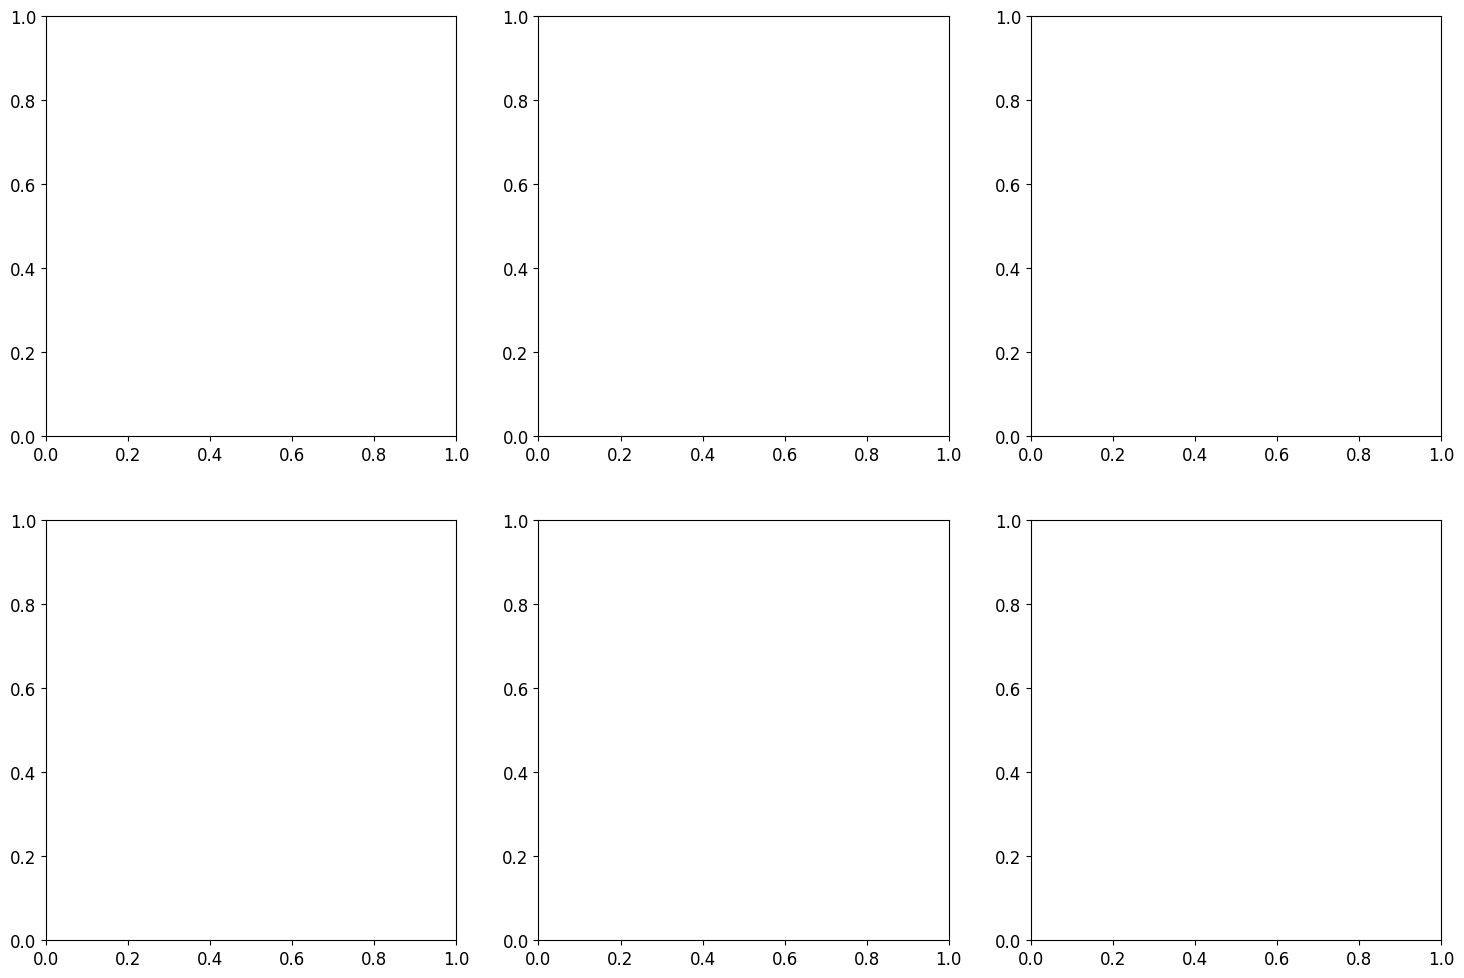

In [9]:
# Create a parameter study
print("Parameter exploration: How do different settings affect the setup?")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Different parameter combinations
param_sets = [
    {'velocity_shear': 1.0, 'density_contrast': 1.0, 'perturbation_amplitude': 0.05},
    {'velocity_shear': 2.0, 'density_contrast': 1.0, 'perturbation_amplitude': 0.05},
    {'velocity_shear': 1.0, 'density_contrast': 3.0, 'perturbation_amplitude': 0.05},
    {'velocity_shear': 1.0, 'density_contrast': 1.0, 'perturbation_amplitude': 0.2},
    {'velocity_shear': 3.0, 'density_contrast': 2.0, 'perturbation_amplitude': 0.1},
    {'velocity_shear': 1.0, 'density_contrast': 0.5, 'perturbation_amplitude': 0.1},
]

titles = [
    'Low shear, no density contrast',
    'High shear, no density contrast', 
    'Low shear, high density contrast',
    'High perturbation amplitude',
    'High shear + density contrast',
    'Inverted density contrast'
]

for i, (params, title) in enumerate(zip(param_sets, titles)):
    # Generate IC with these parameters
    test_ic = generate_kelvin_helmholtz_ic(n_particles_x=100, n_particles_y=50,
                                          box_size=[4.0, 2.0], **params)
    
    # Plot density field
    pos = test_ic['positions']
    vel = test_ic['velocities']
    rho = test_ic['densities']
    
    im = axes[i].scatter(pos[:,0], pos[:,1], c=rho, s=2, cmap='viridis')
    
    # Add velocity arrows
    skip = 15
    axes[i].quiver(pos[::skip,0], pos[::skip,1], 
                  vel[::skip,0], vel[::skip,1], 
                  scale=15, alpha=0.7, color='red', width=0.003)
    
    axes[i].set_title(title, fontsize=10)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_aspect('equal')

plt.tight_layout()
plt.suptitle('Parameter Study: Effect on Initial Conditions', fontsize=16, y=1.02)
plt.show()

## Summary and Next Steps

In this notebook, we've:

1. **Learned about the Kelvin-Helmholtz instability** - its physical origin and importance
2. **Generated initial conditions** with two fluid layers and velocity shear
3. **Created SWIFT-compatible files** for running SPH simulations
4. **Set up parameter files** for the simulation
5. **Developed analysis and visualization tools**
6. **Explored parameter variations** and their effects

### Key Physics Insights:
- The Kelvin-Helmholtz instability grows from small perturbations in shear flows
- Density contrasts can stabilize or destabilize the interface
- The characteristic "cat's eye" structures develop from the velocity shear

### Next Steps:
1. **Run the simulation** with SWIFT if you have it installed
2. **Experiment with different parameters** - try higher density contrasts, different perturbation wavelengths
3. **Add physical effects** - viscosity, cooling, magnetic fields
4. **Move to 3D** - the instability has rich 3D structure

### Challenges to Try:
- Implement multi-wavelength perturbations
- Add a background flow
- Try different density profiles (gradual vs sharp interfaces)
- Compare with linear stability theory predictions

The Kelvin-Helmholtz instability is fundamental to many astrophysical phenomena, from planetary atmospheres to accretion disk flows. Understanding its behavior in SPH simulations is crucial for modeling real astrophysical systems!